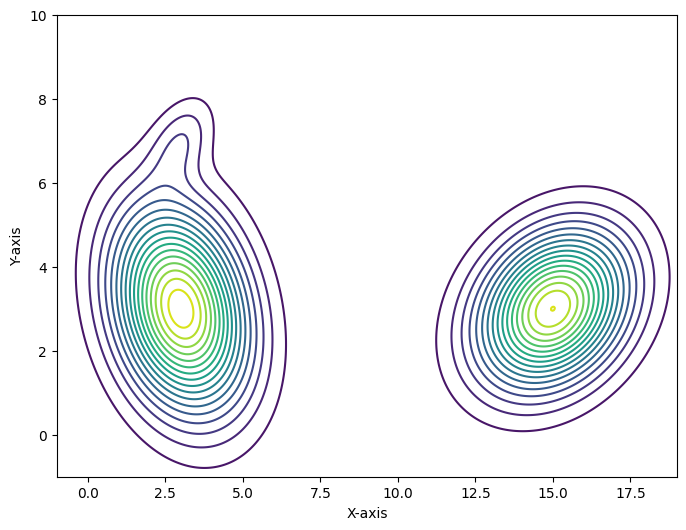

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# define distribution 2

mean11 = [3, 7]
cov11 = [[0.5, 0.2], [0.2, 0.5]]
weight11 = 0.03
#weight11 = 0

mean12 = [3, 3]
cov12 = [[2, -0.5], [-0.5, 2.5]]
weight12 = 1 - weight11

weight1 = [weight11, weight12]

x, y = np.meshgrid(np.linspace(-1, 10, 400), np.linspace(-1, 10, 400))
pos = np.dstack((x, y))


rv1 = multivariate_normal(mean11, cov11)
rv2 = multivariate_normal(mean12, cov12)

z1 = weight1[0] * rv1.pdf(pos) + weight1[1] * rv2.pdf(pos)



# distribution 1
mean2 = [15, 3]
cov2 = [[2.5, 0.5], [0.5, 1.5]]
x2, y2 = np.meshgrid(np.linspace(3, 19, 400), np.linspace(-1, 10, 400))

pos = np.dstack((x2, y2))

rv = multivariate_normal(mean2, cov2)

z2 = rv.pdf(pos)
# Plot the contour
plt.figure(figsize=(8, 6))
plt.contour(x, y, z1, levels=20, cmap='viridis')
plt.contour(x2, y2, z2, levels=20, cmap='viridis')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
# plt.xlim(0, 25)
# plt.ylim(0, 25)
#plt.colorbar(label='Density')
plt.show()


In [2]:
import torch

MEAN_2 = torch.tensor(mean2, dtype=torch.float)
SIGMA_2 = torch.tensor(cov2, dtype=torch.float)

SIGMA_11 = torch.tensor(cov11, dtype=torch.float)
SIGMA_12 = torch.tensor(cov12, dtype=torch.float)
MEAN11 = torch.tensor(mean11, dtype=torch.float)
MEAN12 = torch.tensor(mean12, dtype=torch.float)

MEAN_1 = MEAN11 * weight11 + MEAN12 * weight12
# MEAN_1
SIGMA_1 = weight11 * (SIGMA_11 + (MEAN11 - MEAN_1) @ (MEAN11 - MEAN_1).t()) + \
          weight12 * (SIGMA_12 + (MEAN12 - MEAN_1) @ (MEAN12 - MEAN_1).t())
SIGMA_1


tensor([[ 2.4206, -0.0134],
        [-0.0134,  2.9056]])

In [3]:
import utils as F



def compute_mean_SOUT(mean_list, sigma_list, tau=0.01):
    n = len(mean_list)
    dim = sigma_list[0].shape[1] 

    sigma_tau_list = [torch.eye(dim) + tau/2 * torch.linalg.inv(x) for x in sigma_list]
    
    M_list = []
    for i in range(len(mean_list)):
        M_list.append(
            (torch.norm(torch.linalg.inv(sigma_tau_list[i]), p=2) ** 2 + 1) * torch.eye(dim) \
            - 2 * torch.linalg.inv(sigma_tau_list[i]) \
            + tau/2 * torch.linalg.inv(sigma_tau_list[i]) @ torch.linalg.inv(sigma_list[i]) @ torch.linalg.inv(sigma_tau_list[i])
        )

    
    MEAN_B = torch.linalg.inv(sum(M_list)) @ sum([M_list[i] @ mean_list[i] for i in range(n)])

    return MEAN_B



# compute_mean_SOUT([MEAN_1, MEAN_2], [SIGMA_1, SIGMA_2])


In [4]:
# MEAN_B = compute_mean_SOUT([MEAN_1, MEAN_2], [SIGMA_1, SIGMA_2])
SIGMA_B = F.Bures_manifold_UOT_bary_hybridmethod(
    covariance_matrices=[SIGMA_1, SIGMA_2],
    Sigma_beta_0=torch.eye(2, dtype=torch.float)
)[0]
SIGMA_B

d:\Submission15617_Supplementary_Material\SUOT_Barycenter\utils.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)
d:\Submission15617_Supplementary_Material\SUOT_Barycenter\utils.py:60: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ..\aten\src\ATen\native\Copy.cpp:300.)
  return geometric_mean_matrix.to(torch.float)


tensor([[1.4739, 0.0695],
        [0.0695, 1.3670]])

In [5]:
MEAN_B = compute_mean_SOUT([MEAN_1, MEAN_2], [SIGMA_1, SIGMA_2])
MEAN_B.numpy()

array([8.989241, 3.053463], dtype=float32)

In [6]:
from utils import Bures_manifold_OT_bary
MEAN_B_OT = (weight11 * np.array(mean11) + weight12 * np.array(mean12) + mean2) / 2
# MEAN_B_OT
SIGMA_B_OT = Bures_manifold_OT_bary(
    covariance_matrices=[SIGMA_1, SIGMA_2],
    Sigma_beta_0=torch.eye(2, dtype=torch.float)
).numpy()
print(SIGMA_B_OT)
print(MEAN_B_OT)

[[2.4509752  0.26637477]
 [0.26637495 2.1344247 ]]
[9.   3.06]


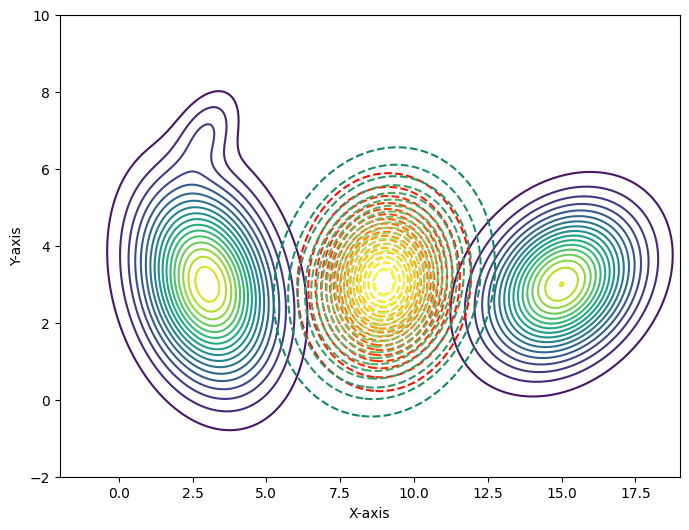

In [7]:
# distribution 1
x1, y1 = np.meshgrid(np.linspace(-1, 10, 400), np.linspace(-1, 10, 400))
pos = np.dstack((x1, y1))


rv1 = multivariate_normal(mean11, cov11)
rv2 = multivariate_normal(mean12, cov12)

z1 = weight1[0] * rv1.pdf(pos) + weight1[1] * rv2.pdf(pos)

#distribution 2
x2, y2 = np.meshgrid(np.linspace(3, 19, 400), np.linspace(-1, 10, 400))

pos = np.dstack((x2, y2))

rv = multivariate_normal(mean2, cov2)

z2 = rv.pdf(pos)

#barycenter
xb, yb = np.meshgrid(np.linspace(0, 13, 400), np.linspace(0, 13, 400))
pos = np.dstack((xb, yb))
rv = multivariate_normal(MEAN_B, SIGMA_B)

zb = rv.pdf(pos)

xbot, ybot = np.meshgrid(np.linspace(-2, 13, 400), np.linspace(-2, 13, 400))
pos = np.dstack((xbot, ybot))
rv = multivariate_normal(MEAN_B_OT, SIGMA_B_OT)

zbot = rv.pdf(pos)

plt.figure(figsize=(8, 6))
plt.contour(x1, y1, z1, levels=20, cmap = 'viridis')
plt.contour(x2, y2, z2, levels=20, cmap = 'viridis')
plt.contour(xb, yb, zb, levels=20, cmap = "autumn", linestyles = 'dashed')
plt.contour(xbot, ybot, zbot, levels=20, cmap = "summer", linestyles = 'dashed')


#plt.title('Contour Plot of a 2D Gaussian Mixture Distribution')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
# plt.xlim(0, 25)
plt.ylim(-2, 10)
#plt.colorbar(label='Density')
plt.show()

In [8]:
print(SIGMA_B_OT)
print(MEAN_B_OT)
print(SIGMA_B)
print(MEAN_B)

[[2.4509752  0.26637477]
 [0.26637495 2.1344247 ]]
[9.   3.06]
tensor([[1.4739, 0.0695],
        [0.0695, 1.3670]])
tensor([8.9892, 3.0535])
